In [1]:
from IPython.display import clear_output
import os,cv2,random,torch,torchvision
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
AllClasses =['alternating process-LWandBM2019',
 'gaussian process - fBm1968',
 'levy process -  BM19051',
 'levy process - beta-stable subordinator',
 'levy process - homogeneous Poisson process',
 'levy process - symmetric 4stable process',
 'multi-state process - CTRW2017',
 'multi-state process - LW2018',
 'random walk - CTRW1965',
 'random walk - CTRW196502',
 'random walk - CTRW196503',
 'random walk - CTRW196504']

class DataProcess(torch.utils.data.Dataset):
    def __init__(self, ImagesPath, ImageTransformer):
        global AllClasses
        def GetImage(Class):
            images = [x for x in os.listdir(ImagesPath[Class]) if x[-3:].lower().endswith('jpg') or x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {Class} examples')
            return images
        
        self.images = {}
        self.Classes = AllClasses
        
        for Class in self.Classes:
            self.images[Class] = GetImage(Class)
            
        self.ImagesPath = ImagesPath
        self.ImageTransformer = ImageTransformer
    def __len__(self):
        return sum([len(self.images[Class]) for Class in self.Classes])
    def __getitem__(self, index):
        Class = random.choice(self.Classes)
        index = index % len(self.images[Class])
        NameOfPicture = self.images[Class][index]
        PathOfPicture = os.path.join(self.ImagesPath[Class], NameOfPicture)
        image = Image.open(PathOfPicture).convert('RGB')
        
        return self.ImageTransformer(image), self.Classes.index(Class)

def AccCalc(LabelsValues,OutputValues) : 
  _,PredictedValues = torch.max(OutputValues, 1)
  return sum((PredictedValues == LabelsValues).numpy())

In [3]:
AllImages = {}
SavedImages = 0
Path = 'C:/Users\shamsan\Desktop\Data-sh-3500'
for folder in os.listdir(Path) : 
  ThisPath = os.path.join(Path,folder)
  AllImages[folder] = []
  for image in os.listdir(ThisPath) : 
    SavedImages+=1
    AllImages[folder].append(os.path.join(ThisPath,image))
AllImages

{'alternating process-LWandBM2019': ['C:/Users\\shamsan\\Desktop\\Data-sh-3500\\alternating process-LWandBM2019\\(1).jpg',
  'C:/Users\\shamsan\\Desktop\\Data-sh-3500\\alternating process-LWandBM2019\\(10).jpg',
  'C:/Users\\shamsan\\Desktop\\Data-sh-3500\\alternating process-LWandBM2019\\(100).jpg',
  'C:/Users\\shamsan\\Desktop\\Data-sh-3500\\alternating process-LWandBM2019\\(1000).jpg',
  'C:/Users\\shamsan\\Desktop\\Data-sh-3500\\alternating process-LWandBM2019\\(1001).jpg',
  'C:/Users\\shamsan\\Desktop\\Data-sh-3500\\alternating process-LWandBM2019\\(1002).jpg',
  'C:/Users\\shamsan\\Desktop\\Data-sh-3500\\alternating process-LWandBM2019\\(1003).jpg',
  'C:/Users\\shamsan\\Desktop\\Data-sh-3500\\alternating process-LWandBM2019\\(1004).jpg',
  'C:/Users\\shamsan\\Desktop\\Data-sh-3500\\alternating process-LWandBM2019\\(1005).jpg',
  'C:/Users\\shamsan\\Desktop\\Data-sh-3500\\alternating process-LWandBM2019\\(1006).jpg',
  'C:/Users\\shamsan\\Desktop\\Data-sh-3500\\alternating proc

In [4]:
len(AllImages.keys()),SavedImages

(12, 42000)

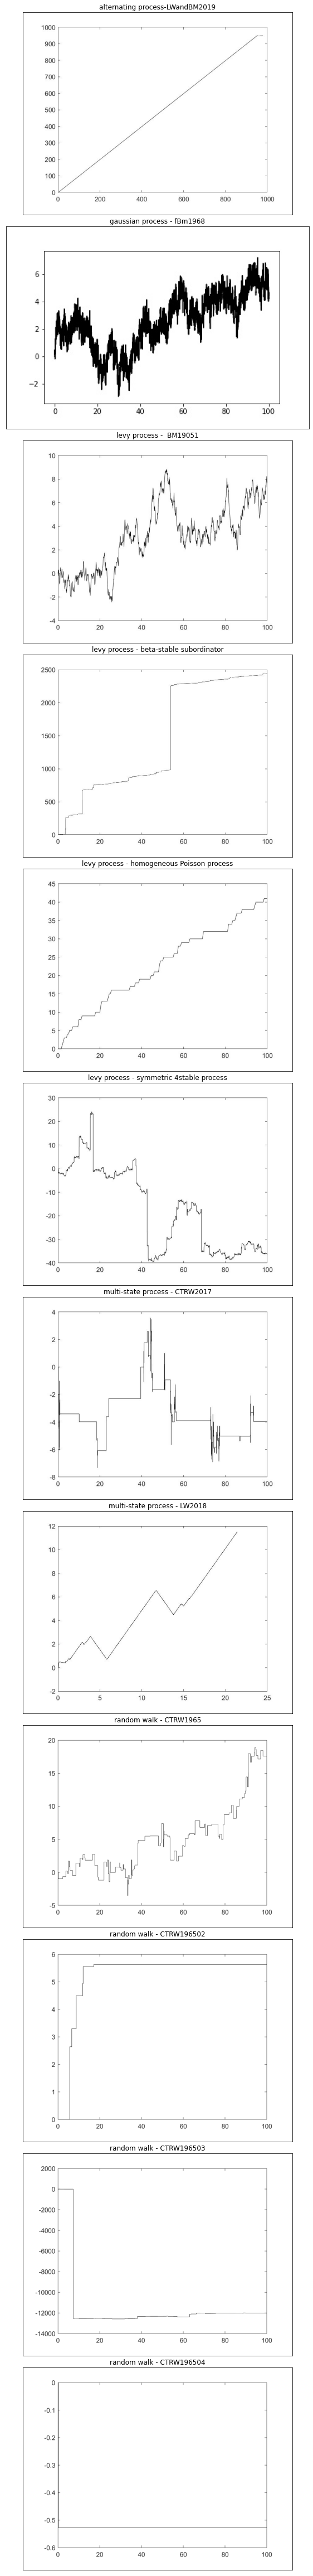

In [17]:
def ShowImages() : 
  global AllImages

  fig, ax = plt.subplots(12, 1, figsize=(64,64))  
  fig.tight_layout(pad=0.010)
  for i in range(len(ax)): 
    im = np.random.choice(AllImages[list(AllImages.keys())[i]])
    ax[i].imshow(plt.imread(im))
    ax[i].set_title(list(AllImages.keys())[i])

  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
ShowImages()        

In [18]:
SavedImages,TrainingDataSize,TestingDataSize=0,0,0
ThisModel,ThisLossFunction ,ThisOptimizer = None,None,None
ThisTransformer = torchvision.transforms.Compose([torchvision.transforms.Resize(size=(50,50)),
                                                  #torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor()])

In [19]:
ImagesPath = {i:os.path.join(r'C:/Users\shamsan\Desktop\Data-sh-3500',i) for i in AllClasses}

ProcessedData = DataProcess(ImagesPath, ThisTransformer)

TrainingDataSize = 0.80

TrainingSize = int(TrainingDataSize * len(ProcessedData))
TestingSize = len(ProcessedData) - TrainingSize

TrainingData, TestingData = torch.utils.data.random_split(ProcessedData, [TrainingSize, TestingSize])
TrainingDataSize,TestingDataSize=len(TrainingData), len(TestingData)
print("Length of train set   :  ", len(TrainingData))
print("Length of test set    :  ", len(TestingData))


Found 3500 alternating process-LWandBM2019 examples
Found 3500 gaussian process - fBm1968 examples
Found 3500 levy process -  BM19051 examples
Found 3500 levy process - beta-stable subordinator examples
Found 3500 levy process - homogeneous Poisson process examples
Found 3500 levy process - symmetric 4stable process examples
Found 3500 multi-state process - CTRW2017 examples
Found 3500 multi-state process - LW2018 examples
Found 3500 random walk - CTRW1965 examples
Found 3500 random walk - CTRW196502 examples
Found 3500 random walk - CTRW196503 examples
Found 3500 random walk - CTRW196504 examples
Length of train set   :   33600
Length of test set    :   8400


In [20]:
BatchSize = 10

TrainingDataLength = torch.utils.data.DataLoader(TrainingData, batch_size = BatchSize, shuffle = True)
TestingDataLength = torch.utils.data.DataLoader(TestingData, batch_size=BatchSize, shuffle=True)


print("Length of training batches", len(TrainingDataLength))
print("Lentgth of test batches", len(TestingDataLength))


Length of training batches 3360
Lentgth of test batches 840


In [21]:
SelectedModel  = torchvision.models.vgg16(pretrained=True)
print(SelectedModel)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
SelectedModel.fc = torch.nn.Linear(in_features=4096, out_features=12)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(SelectedModel.parameters(), lr=0.00001)  

For Epoch Number 30
---------------------------------------------
Train Loss is 0.04 & Train Accuracy is 0.98 
Test Loss is 0.03 & Test Accuracy is 0.99


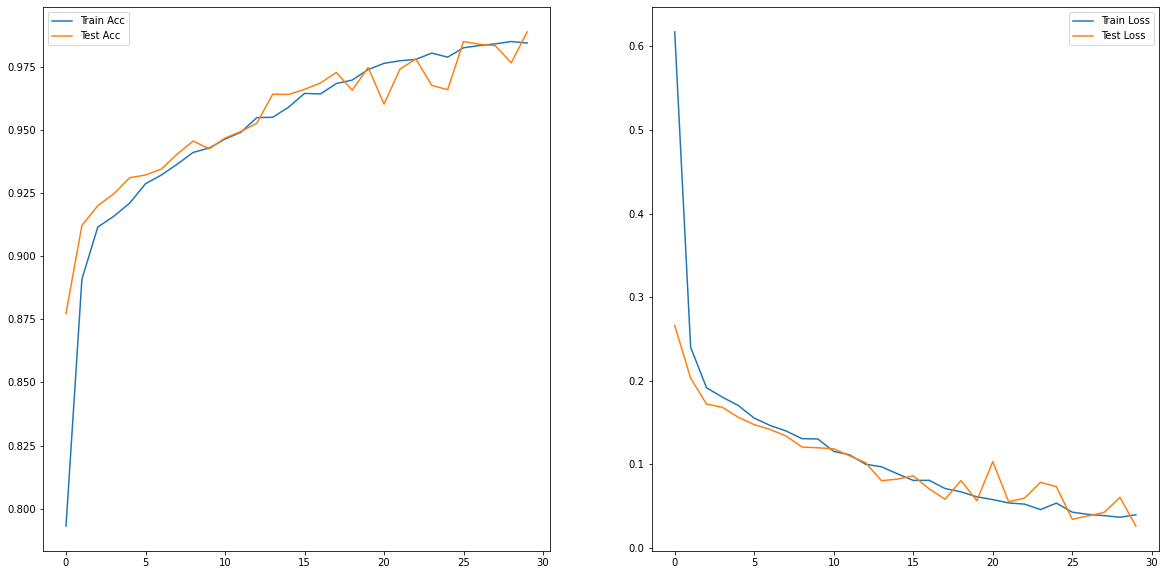

Wall time: 5d 2h 20min 55s


In [24]:
%%time
NumberOfEpochs = 30
ThisModel = SelectedModel
 
ThisOptimizer = optimizer

ThisLossFunction=loss_fn

AccuracyTraining,AccuracyTesting,LossTraining,LossTesting = [],[],[],[]
for j in range(NumberOfEpochs):
  print(j)
  TrainLoss,TestLoss,TrainAccuracy,TestAccuracy  = 0,0,0,0
  ThisModel.train()
  i=0
  for X,y in TrainingDataLength:
    i+=1
    ThisOptimizer.zero_grad()
    ThisOutput = ThisModel(X)
    ThisLoss = ThisLossFunction(ThisOutput,y)
    ThisLoss.backward()
    ThisOptimizer.step()
    TrainLoss += ThisLoss.item()
    TrainAccuracy += AccCalc(y,ThisOutput)
  TrainLoss /=i
  TrainAccuracy /=TrainingDataSize
  
  AccuracyTraining.append(TrainAccuracy)
  LossTraining.append(TrainLoss)
  
  ThisModel.eval()
  i=0
  for X,y in TestingDataLength:
    i+=1
    ThisOutput = ThisModel(X)
    ThisLoss = ThisLossFunction(ThisOutput,y)
    TestLoss += ThisLoss.item()
    TestAccuracy += AccCalc(y,ThisOutput)
  
  TestLoss/=i
  TestAccuracy /=TestingDataSize
  AccuracyTesting.append(TestAccuracy)
  LossTesting.append(TestLoss)
  
  clear_output(wait=True)
  print(f'For Epoch Number {j+1}')
  print('---------------------------------------------')
  print(f'Train Loss is {np.round(TrainLoss,2)} & Train Accuracy is {np.round(TrainAccuracy,2)} ')
  print(f'Test Loss is {np.round(TestLoss,2)} & Test Accuracy is {np.round(TestAccuracy,2)}')
  torch.save(ThisModel, f"C:/Users\shamsan\Desktop\Data-sh-3500/vgg16model.h5")
  plt.figure(figsize=(20,10))
  XValue = [k for k in range(j+1)]
  plt.subplot(1,2,1)
  plt.plot(XValue,AccuracyTraining,label='Train Acc')
  plt.plot(XValue,AccuracyTesting,label='Test Acc')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(XValue,LossTraining,label='Train Loss')
  plt.plot(XValue,LossTesting,label='Test Loss')
  plt.legend()
  plt.show()
 

In [25]:
ThisModel = torch.load('C:/Users\shamsan\Desktop\Data-sh-3500/vgg16model.h5')

In [26]:
i=0
AllYValue,AllOutput = [],[]
ThisModel.eval()
ThisLossFunction = torch.nn.CrossEntropyLoss()
TestLoss,TestAccuracy  = 0,0
for X,y in TestingDataLength:
  i+=1
  # if i ==50 : break
  if i%50==0 : print(i)
  ThisOutput = ThisModel(X)
  AllYValue.extend(y)
  _,PredictedValues = torch.max(ThisOutput, 1)
  AllOutput.extend([int(i) for i in PredictedValues])
  ThisLoss = ThisLossFunction(ThisOutput,y)
  TestLoss += ThisLoss.item()
  TestAccuracy += AccCalc(y,ThisOutput)
z=0
for a,b in zip(AllOutput,[int(i) for i in AllYValue]) : 
  if a==b : z+=1
z/len(AllOutput)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800


0.9875

In [27]:
TestLoss/i,TestAccuracy/i*0.10

(0.029363937171199166, 0.9875)

In [28]:
print(f'Model Accuracy is {np.round(TestAccuracy/i*0.10,2)} and loss is {np.round(TestLoss/i,2)}')

Model Accuracy is 0.99 and loss is 0.03


In [29]:
AllYValue = [int(i) for i in AllYValue]

In [30]:
from sklearn.metrics import classification_report,confusion_matrix
confusion_matrix(AllOutput,AllYValue)

array([[736,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 726,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 694,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 683,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 699,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 662,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 680,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 732,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 710,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 641,   0,  37],
       [  0,   0,   0,   0,   0,   0,   0,   0,   2,   0, 677,   0],
       [  0,   0,   0,   0,   0,   2,   0,   0,   0,  57,   6, 655]],
      dtype=int64)

In [39]:
print(classification_report(AllOutput,AllYValue))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       1.00      1.00      1.00       711
           2       1.00      1.00      1.00       677
           3       1.00      1.00      1.00       715
           4       1.00      1.00      1.00       696
           5       1.00      1.00      1.00       662
           6       1.00      1.00      1.00       723
           7       1.00      1.00      1.00       708
           8       1.00      0.99      1.00       710
           9       0.96      0.99      0.97       692
          10       0.97      1.00      0.99       659
          11       0.99      0.94      0.97       740

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400



In [3]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import itertools
import numpy as np

In [4]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):


    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig= plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=85)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            fig.savefig('confusion_matrix.eps')

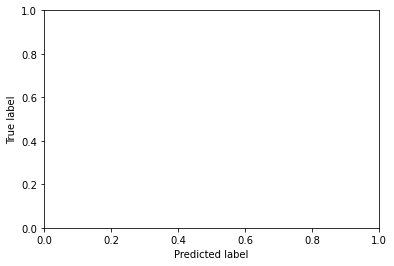

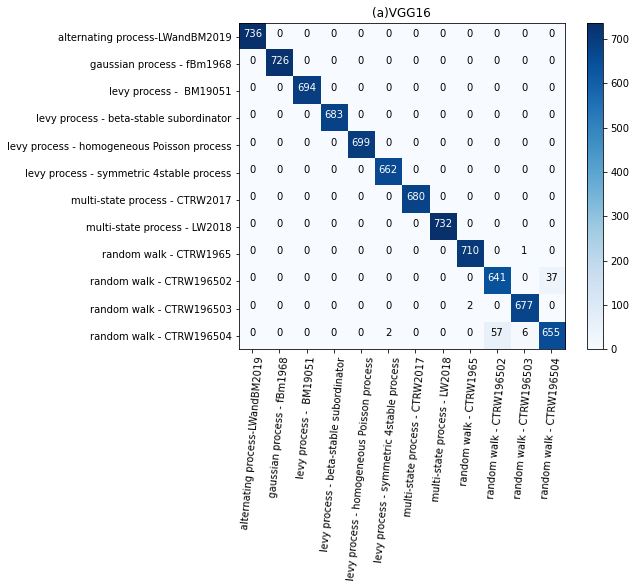

In [6]:
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
conf_matrix = [[736,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 726,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 694,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 683,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 699,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 662,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 680,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 732,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 710,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 641,   0,  37],
       [  0,   0,   0,   0,   0,   0,   0,   0,   2,   0, 677,   0],
       [  0,   0,   0,   0,   0,   2,   0,   0,   0,  57,   6, 655]]

Calss_Names = ['alternating process-LWandBM2019',
 'gaussian process - fBm1968',
 'levy process -  BM19051',
 'levy process - beta-stable subordinator',
 'levy process - homogeneous Poisson process',
 'levy process - symmetric 4stable process',
 'multi-state process - CTRW2017',
 'multi-state process - LW2018',
 'random walk - CTRW1965',
 'random walk - CTRW196502',
 'random walk - CTRW196503',
 'random walk - CTRW196504']
plot_confusion_matrix(cm = np.array(conf_matrix),
                      normalize    = False,
                      target_names = Calss_Names,
                      title   ="(a)VGG16")
